### Data Prep

In [26]:
from datasets import load_dataset
ds = load_dataset("microsoft/cats_vs_dogs")

In [27]:
import numpy as np

In [28]:
from PIL import Image, ImageOps


In [29]:
def preprocessing(example):
    import numpy as np
    size = (64,64)
    img = example['image']
    img = img.convert('RGB')
    img_resized = img.resize(size)
    img_processed = np.array(img_resized, dtype=np.float32)/255
    img_flatten = img_processed.flatten()
    example['image'] = img_flatten
    return example

ds_resized = ds['train'].map(preprocessing, num_proc=4)


In [30]:
ds_resized.shape

(23410, 2)

In [31]:
ds_resized['image']

Column([<PIL.TiffImagePlugin.TiffImageFile image mode=F size=1x12288 at 0x267DE2B2350>, <PIL.TiffImagePlugin.TiffImageFile image mode=F size=1x12288 at 0x267DE2B2FD0>, <PIL.TiffImagePlugin.TiffImageFile image mode=F size=1x12288 at 0x267DE2B3110>, <PIL.TiffImagePlugin.TiffImageFile image mode=F size=1x12288 at 0x267DE2B2AD0>, <PIL.TiffImagePlugin.TiffImageFile image mode=F size=1x12288 at 0x267DE2B2E90>, ...])

In [32]:
vector_img = np.array(ds_resized['image'][:15000])

In [33]:
vector_img = vector_img.squeeze()

In [34]:
vector_img.shape

(15000, 12288)

In [35]:
vector_labels = np.array(ds['train']['labels'][:15000],dtype = bool)

In [57]:
vector_labels = vector_labels.reshape(1, -1)  # (1, 15000)
vector_labels.shape

(1, 15000)

In [58]:
# def split_function(database, x):
#     size_train = round(ds_flatten.shape[0]*x)
#     split_train = database[:size_train]
#     split_test = database[size_train:]
#     return split_train, split_test

# (split_train, split_test) = split_function(ds_flatten,x = 0.8)
# split_test



### NN 
Vectorization


In [79]:
import numpy as np
logistic_regression = {}

def log_reg(z):
    return 1/(1+np.exp(-z))

def d_log_reg(a):
    return a * (1 - a)
logistic_regression['activation'] = log_reg
logistic_regression['derivate'] = d_log_reg

ReLinearUnit = {}
def relu(z):
    return np.maximum(0,z)

def d_relu(z):
    return (z > 0).astype(float)

ReLinearUnit['activation'] = relu
ReLinearUnit['derivate'] = d_relu

class NN():
    def __init__(self,L,nx,learning_rate,activation_funcs): #only hidden layers
        self.L = L #number of hidden layers
        self.nx = nx #number of units per layer
        self.learning_rate = learning_rate
        self.activation_funcs = activation_funcs
        self.weights = [None] * self.L
        print(self.weights)
        self.bias = [None] * self.L
        self.dW = [None] * self.L
        self.Z = [None] * self.L
        self.A = [None] * self.L
        self.dZ = [None] * self.L
        self.dA = [None] * self.L
        self.db = [None] * self.L


    def random_weights(self,n0):
        self.weights[0] = np.random.randn(self.nx[0],n0)* np.sqrt(2 / self.nx[0])
        #self.weights[0] = np.random.randn(n_in, n_out) * np.sqrt(2 / n_in)

        self.bias[0] = np.random.randn(self.nx[0],1)* np.sqrt(2 / self.nx[0])
        print('w shape, layer :',0,':',np.shape(self.weights[0]))

        for layer in range(1,self.L):
            self.weights[layer] = np.random.randn(self.nx[layer],self.nx[layer-1])* np.sqrt(2 / self.nx[layer-1])
            self.bias[layer] = np.random.randn(self.nx[layer],1)* np.sqrt(2 / self.nx[layer-1])
            print('w shape, layer :',layer,':',np.shape(self.weights[layer]))
            print(self.weights[layer],self.bias[layer])
        print('random weights initialized')
        print('w',self.weights[self.L-1],'b',self.bias[self.L-1])
        
    
    def forward_pass(self,X,Y):
        print('Forward pass n[0]')
        self.m = X.shape[0]
        self.Z[0] = np.dot(self.weights[0],X.T)+self.bias[0] # T car 
        self.A[0] = self.activation_funcs[0]['activation'](self.Z[0])
        for layer in range(1,self.L):
            print('Forward pass n[',layer,']')
            self.Z[layer] = np.dot(self.weights[layer],self.A[layer-1])+self.bias[layer]
            self.A[layer] = self.activation_funcs[layer]['activation'](self.Z[layer])
            print('A shape layer',layer,'is :',self.A[layer].shape)
            print('DEAD Neurone layer :',layer,'is',np.mean(self.A[layer] == 0))
        #cost computation
        A = self.A[self.L-1]
        cost = -1/self.m*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))
        print('forward pass runned successfuly')
        return cost
    
    def backward_pass(self,X,Y):
        dL = 1
        L = self.L
        print('Backward pass :',L-1)

        self.dA[L-1] = -((Y/self.A[L-1])-(1-Y)/(1-self.A[L-1])) 
        self.dZ[L-1] = self.dA[L-1]*self.activation_funcs[L-1]['derivate'](self.A[L-1]) #(n[l-1], m) da(n[l-1],m) a (n[l-1],m)
        self.dW[L-1] = 1/self.m*np.dot(self.dZ[L-1],self.A[L-2].T) # = (n[l-1],m)(n[l-2],m)
        self.db[L-1] = np.mean(self.dZ[L-1], axis= 1,keepdims=True)
        for layer in range(self.L-2,0,-1):
            print('Backward pass :', layer)
            self.dA[layer] = self.dA[layer] = np.dot(self.weights[layer+1].T, self.dZ[layer+1])
            self.dZ[layer] = self.dA[layer]*self.activation_funcs[layer]['derivate'](self.A[layer]) 
            self.dW[layer] = 1/self.m*np.dot(self.dZ[layer],self.A[layer-1].T) #(n[l],n[l-1]) = (n[l],m)(m,n[l-1]) => où passe les m et comment faire pour avoir une update moyenne
            self.db[layer] = np.mean(self.dZ[layer], axis= 1,keepdims=True) # (n[l],1) => avec la moyenne 
        self.dA[0] =  np.dot(self.weights[1].T,self.dZ[1]) 
        self.dZ[0] = self.dA[0]*self.activation_funcs[0]['derivate'](self.A[0]) 
        self.dW[0] = 1/self.m*np.dot(self.dZ[0],X) #(10,12288)

        self.db[0] = np.mean(self.dZ[0], axis= 1,keepdims=True) # (n[l],1) => avec la moyenne 
        print('Backward pass : successfull')
        print('updating weights')
        #update weights
        for layer in range(self.L-1,-1,-1):
            self.weights[layer] = self.weights[layer] -self.learning_rate*self.dW[layer]
            self.bias[layer] = self.bias[layer] - self.learning_rate*self.db[layer]
            print('weights',layer,'updated')
        print('weights updated')
        
        


    
    


In [80]:
quick_test = NN(L = 3,
                nx = np.array([10,9,1]),
                learning_rate=0.001,
                activation_funcs=[ReLinearUnit,ReLinearUnit,logistic_regression])

[None, None, None]


In [81]:
quick_test.random_weights(n0 = np.shape(vector_img)[1])

w shape, layer : 0 : (10, 12288)
w shape, layer : 1 : (9, 10)
[[ 0.62157149  0.18509149  0.0822444  -0.22165705 -0.37036341 -0.58729623
   0.20350324 -0.40936374  0.09098057  0.29351352]
 [-0.40098026 -0.56285648 -0.37206951 -0.04227868 -0.23698337  0.65554899
  -0.3538778  -0.39109381 -0.80507069  0.29200707]
 [ 0.03862179 -0.28809546 -0.24528384  0.83135153 -0.32386473  0.57651758
  -0.57222745  0.33534545 -0.48195237  0.68745376]
 [-0.28351765  0.64331873  0.52912627 -0.33260575  0.35866747 -0.26761663
  -0.09398136  0.23620169  0.14047452  0.19273115]
 [-0.47706994 -0.19898846  0.7540922   0.99847278 -0.39150302 -0.09413305
  -0.2816885  -0.53491204  0.48864981 -0.51593254]
 [ 0.31183097  0.1100149   0.51354136 -0.9134414   0.29441898 -0.3598081
  -0.05415241 -0.48262091 -0.12088084 -0.03876762]
 [ 0.49708359  0.34407984 -0.80533555 -0.18532012 -0.01044817  0.12953286
  -0.92839413  0.48650949 -0.12005936  0.15265046]
 [ 0.22884098 -0.23482503 -0.14981038  0.07734274  0.37224244 -0

In [82]:
last_cost =[]
for i in range(40):
    print('iteration number : ',  i)
    quick_test.forward_pass(vector_img,vector_labels)
    print('forward pass successfull')
    quick_test.backward_pass(vector_img,vector_labels)
    print('backward_pass successfull')
    last_cost.append(quick_test.forward_pass(vector_img,vector_labels))

print(last_cost)

iteration number :  0
Forward pass n[0]
Forward pass n[ 1 ]
A shape layer 1 is : (9, 15000)
DEAD Neurone layer : 1 is 0.6634074074074074
Forward pass n[ 2 ]
A shape layer 2 is : (1, 15000)
DEAD Neurone layer : 2 is 0.0
forward pass runned successfuly
forward pass successfull
Backward pass : 2
Backward pass : 1
Backward pass : successfull
updating weights
weights 2 updated
weights 1 updated
weights 0 updated
weights updated
backward_pass successfull
Forward pass n[0]
Forward pass n[ 1 ]
A shape layer 1 is : (9, 15000)
DEAD Neurone layer : 1 is 0.6641407407407407
Forward pass n[ 2 ]
A shape layer 2 is : (1, 15000)
DEAD Neurone layer : 2 is 0.0
forward pass runned successfuly
iteration number :  1
Forward pass n[0]
Forward pass n[ 1 ]
A shape layer 1 is : (9, 15000)
DEAD Neurone layer : 1 is 0.6641407407407407
Forward pass n[ 2 ]
A shape layer 2 is : (1, 15000)
DEAD Neurone layer : 2 is 0.0
forward pass runned successfuly
forward pass successfull
Backward pass : 2
Backward pass : 1
Backwa

[np.float64(5.335447254542631), np.float64(5.0298520114753265), np.float64(4.736562221098001), np.float64(4.454729080333674), np.float64(4.18416139849513), np.float64(3.925541144566514), np.float64(3.6792715337861894), np.float64(3.446288075642222), np.float64(3.2282856440378827), np.float64(3.026742684224051), np.float64(2.84217603110457), np.float64(2.676520572397846), np.float64(2.5304492706521953), np.float64(2.403969926013474), np.float64(2.2967847823913825), np.float64(2.2071593412027752), np.float64(2.1338256549428585), np.float64(2.0747886864752134), np.float64(2.027787503058117), np.float64(1.9901093055054828), np.float64(1.959902997701865), np.float64(1.9352642506551732), np.float64(1.9148271056508435), np.float64(1.8972880790456395), np.float64(1.882084260788646), np.float64(1.8683319631287199), np.float64(1.8555464102142727), np.float64(1.843404273864527), np.float64(1.8316881631472888), np.float64(1.8203184189359425), np.float64(1.80917697209178), np.float64(1.798114898966

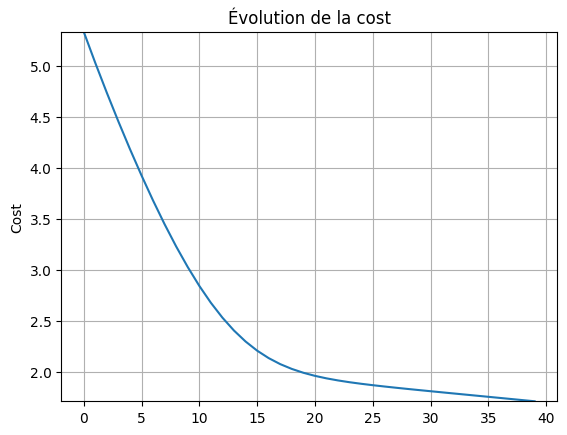

In [83]:
import matplotlib.pyplot as plt

x = [i for i in range(40)]
print(last_cost)
plt.plot(x, last_cost)
plt.ylim(min(last_cost), max(last_cost))    
plt.ylabel("Cost")
plt.title("Évolution de la cost")
plt.grid(True)
plt.show()
